# RADI 6060 Homework 1
### Gweneth Andersen
##### 2/1/2024
<br>
After coding my solution to Problem 1 in C++, I decided to switch to Python for the rest of the assignment. This is partially due to the need for efficient and readable code and largely due to my relative inexperience with plotting in C++. Here, the first code block contains the entirety of the algorithms I designed to solve Problems 2, 3, and 4 <i>(except for some output formatting)</i>. I adopted a heavily object-oriented approach to avoid repeating myself, and took many opportunities to condense for-loops into function mapping expressions and list comprehensions.

In [71]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from statistics import NormalDist


# random number generator using the multiplicative congruential algorithm
class MultiplicativeCongruentialGenerator():
    def __init__(self, initialSeed: int, I1: int, M: int): 
        self.multiplier = I1
        self.modulus = M
        self.seed = initialSeed % self.modulus
        self.randomNumber = self.seed / self.modulus
        self.seeds = [self.seed]
        self.randomNumbers = [self.randomNumber]
    
    # generate and return the next random number in the multiplicative congruential sequence
    def generateNext(self):
        newSeed = (self.multiplier * self.seed) % self.modulus
        self.seed = newSeed
        self.seeds.append(self.seed)
        newRandomNumber = newSeed / self.modulus
        self.randomNumber = newRandomNumber
        self.randomNumbers.append(self.randomNumber)
        return newRandomNumber
    
    # generate N more random numbers and return them in a list
    def generateNextN(self, N: int):
        newRandomNumbers = []
        for i in range(N):
            newRandomNumber = self.generateNext()
            newRandomNumbers.append(newRandomNumber)
        return newRandomNumbers

            
# handler for Monte Carlo integration methods
class MCIntegrator():
    def __init__(self, RNG: MultiplicativeCongruentialGenerator):
        self.RNG = RNG
    
    # integration routine handler
    def integrate(self, by: str, **kwargs):
        if by == "mean":
            return self.mean_method(**kwargs)
        elif by == "rejection":
            return self.rejection_method(**kwargs)
        else:
            return "ERROR: Specified method of integration has not yet been implemented."
            
    # compute the definite integral of a numeric function of a single variable using the mean method for some number of histories
    def mean_method(self, func: Callable[float, float], lower: float, upper: float, histories: int):
        # make sure there are enough random numbers
        if histories > len(self.RNG.randomNumbers):
            nextN = self.RNG.generateNextN(histories - len(self.RNG.randomNumbers))
                                   
        # map random numbers to domain between limits of integration
        x = list(map(lambda R: lower + R*(upper - lower), self.RNG.randomNumbers))
                
        # evaluate function at each number in random domain
        y = list(map(func, x))
    
        # evaluate integral
        mean = sum(y)/len(y)
        integral = mean*(upper - lower)
        return integral
    
    # visualize the mean method at each number of histories from 10 up to max_histories
    def visualize_mean_method(self, func: Callable[float, float], lower: float, upper: float, max_histories: int, ax=None):
        if max_histories <= 10:
            print("ERROR: Called visualize_mean_method with insufficient histories. max_histories argument should be greater than 10.")
            return
        
        # integrate for each number of histories
        history_sizes = list(range(10, max_histories))
        computed_integrals = [self.integrate(by="mean", func=func, lower=lower, upper=upper, histories=i) for i in history_sizes]
        
        # visualize
        if ax is None:
            fig, ax = plt.subplots(figsize=(10,6))
            
        ax.plot(history_sizes, computed_integrals, label="Computed")
        name = "f(x)"
        if func.__name__ == "cube":
            analytical_integrals = [(1/4)*(upper**4 - lower**4) for _ in history_sizes]
            ax.plot(history_sizes, analytical_integrals, label="Analytical")
            name = "x^3"
        elif func.__name__ == "normal":
            analytical_integrals = [NormalDist(mu=0, sigma=1).cdf(upper) - NormalDist(mu=0, sigma=1).cdf(lower) for _ in history_sizes]
            ax.plot(history_sizes, analytical_integrals, label="Analytical")
            name = "Standard Normal Distribution"
        
        ax.set_title("Monte Carlo Integration of {} between {} and {}".format(name, lower, upper), size=18, pad=15)
        ax.set_xlabel("Number of Histories", size=15, labelpad=15)
        ax.set_ylabel("Computed Integral", size=15, labelpad=15)
        ax.legend()
        return ax, computed_integrals
        
    # compute the definite integral of a numeric function of a single variable using the rejection method for some number of histories
    # NOTE: there is a two-random number to one-history correspondence here, so if there are fewer random numbers in the RNG than the
    # specified number of histories, more will be generated
    def rejection_method(self, func: Callable[float, float], lower: float, upper: float, histories: int, func_max: float=None):
        # make sure there are enough random numbers
        if 2*histories > len(self.RNG.randomNumbers):
            nextN = self.RNG.generateNextN(2*histories - len(self.RNG.randomNumbers))
            
        # approximate maximum value of the function between lower and upper bounds
        if not func_max:
            func_max = max(list(map(func, list(np.linspace(lower, upper, 1000)))))
        
        # map half of the random numbers to the domain of integration
        x = list(map(lambda R: lower + R*(upper - lower), self.RNG.randomNumbers[0:(2*histories):2]))

        # map second half of the random numbers to the domain between 0 and func_max
        y = list(map(lambda R: 0 + R*(func_max - 0), self.RNG.randomNumbers[1:(2*histories):2]))
        
        # evaluate function at each number in random domain
        y_analytical = list(map(func, x))
        # ***make sure none of the function values are negative***
        if any(list(map(lambda val: val < 0, y_analytical))):
            print("ERROR: The function passed to rejection_method has negative values. Only numbers between zero and the function's global maximum are considered.")
            return
        
        # count number of points that are under the function's curve
        n_within = sum([(lambda y1, y2: int(y1 > y2))(y1, y2) for y1, y2 in zip(y_analytical, y)])
        
        # evaluate integral
        integral = (n_within/histories)*(upper - lower)*func_max
        
        return integral
    
    # visualize the rejection method at each number of histories from 10 up to max_histories
    def visualize_rejection_method(self, func: Callable[float, float], lower: float, upper: float, max_histories: int, ax=None):
        if max_histories <= 10:
            print("ERROR: Called visualize_rejection_method with insufficient histories. max_histories argument should be greater than 10.")
            return
        
        # integrate for each number of histories
        history_sizes = list(range(10, max_histories))
        func_max = max(list(map(func, list(np.linspace(lower, upper, 1000))))) # save time by computing it here
        computed_integrals = [self.integrate(by="rejection", func=func, lower=lower, upper=upper, histories=i, func_max=func_max) for i in history_sizes]
        
        # visualize
        if ax is None:
            fig, ax = plt.subplots(figsize=(10,6))
            
        ax.plot(history_sizes, computed_integrals, label="Computed")
        name = "f(x)"
        if func.__name__ == "cube":
            analytical_integrals = [(1/4)*(upper**4 - lower**4)]*len(history_sizes)
            ax.plot(history_sizes, analytical_integrals, label="Analytical")
            name = "x^3"
        elif func.__name__ == "normal":
            analytical_integrals = [NormalDist(mu=0, sigma=1).cdf(upper) - NormalDist(mu=0, sigma=1).cdf(lower)]*len(history_sizes)
            ax.plot(history_sizes, analytical_integrals, label="Analytical")
            name = "Standard Normal Distribution"
        
        ax.set_title("Monte Carlo Integration of {} between {} and {}".format(name, lower, upper), size=18, pad=15)
        ax.set_xlabel("Number of Histories", size=15, labelpad=15)
        ax.set_ylabel("Computed Integral", size=15, labelpad=15)
        ax.legend()
        return ax, computed_integrals
    
    # visualize both mean and rejection methods on same plot
    def visualize_mean_and_rejection_methods(self, func: Callable[float, float], lower: float, upper: float, max_histories: int, ax=None):
        if max_histories <= 10:
            print("ERROR: Called visualize_mean_and_rejection_methods with insufficient histories. max_histories argument should be greater than 10.")
            return
        
        # integrate for each number of histories
        history_sizes = list(range(10, max_histories))
        func_max = max(list(map(func, list(np.linspace(lower, upper, 1000))))) # save time by computing it here
        mean_method_computed_integrals = [self.integrate(by="mean", func=func, lower=lower, upper=upper, histories=i) for i in history_sizes]
        rejection_method_computed_integrals = [self.integrate(by="rejection", func=func, lower=lower, upper=upper, histories=i, func_max=func_max) for i in history_sizes]
        
        # visualize
        if ax is None:
            fig, ax = plt.subplots(figsize=(10,6))
            
        ax.plot(history_sizes, mean_method_computed_integrals, label="Mean Method")
        ax.plot(history_sizes, rejection_method_computed_integrals, label="Rejection Method")
        name = "f(x)"
        if func.__name__ == "cube":
            analytical_integrals = [(1/4)*(upper**4 - lower**4)]*len(history_sizes)
            ax.plot(history_sizes, analytical_integrals, label="Analytical")
            name = "x^3"
        elif func.__name__ == "normal":
            analytical_integrals = [NormalDist(mu=0, sigma=1).cdf(upper) - NormalDist(mu=0, sigma=1).cdf(lower)]*len(history_sizes)
            ax.plot(history_sizes, analytical_integrals, label="Analytical")
            name = "Standard Normal Distribution"
        
        ax.set_title("Monte Carlo Integration of {} between {} and {}".format(name, lower, upper), size=18, pad=15)
        ax.set_xlabel("Number of Histories", size=15, labelpad=15)
        ax.set_ylabel("Computed Integral", size=15, labelpad=15)
        ax.legend()
        return ax, mean_method_computed_integrals, rejection_method_computed_integrals
        
    # visualize slopes of tally fluctuations of both mean and rejection methods on same plot
    def visualize_tally_fluctuations(self, func: Callable[float, float], lower: float, upper: float, max_histories: int, ax=None):
        if max_histories <= 10:
            print("ERROR: Called visualize_tally_fluctuations with insufficient histories. max_histories argument should be greater than 10.")
            return
            
        # integrate for each number of histories
        history_sizes = list(range(10, max_histories))
        func_max = max(list(map(func, list(np.linspace(lower, upper, 1000))))) # save time by computing it here
        mm = [self.mean_method(func, lower, upper, i) for i in history_sizes]
        rm = [self.rejection_method(func, lower, upper, i, func_max) for i in history_sizes]
        
        # compute tally fluctuations
        mean_method_tally_slope = [(mm[i+1] - mm[i])/mm[i] for i in range(len(mm) - 1)]
        rejection_method_tally_slope = [(rm[i+1] - rm[i])/rm[i] for i in range(len(rm) - 1)]
        
        # visualize
        if ax is None:
            fig, ax = plt.subplots(figsize=(10,6))
            
        if func.__name__ == "cube":
            name = "x^3"
        elif func.__name__ == "normal":
            name = "Standard Normal Distribution"
            
        ax.plot(history_sizes[:-1], mean_method_tally_slope, label="Mean Method")
        ax.plot(history_sizes[:-1], rejection_method_tally_slope, label="Rejection Method")
        ax.set_title("Tally Fluctuation of MC Integration of {} between {} and {}".format(name, lower, upper), size=18, pad=15)
        ax.set_xlabel("Number of Histories", size=15, labelpad=15)
        ax.set_ylabel("Slope of Tally Fluctuation", size=15, labelpad=15)
        ax.legend()
        return ax, mean_method_tally_slope, rejection_method_tally_slope
    
    # sample uniformly over a circular disk of a certain radius centered at the origin to compute its area using the rejection method
    # repeats and returns computed area values for each run size from 10 to max_histories
    def integrate_uniform_disk(self, radius: float, max_histories: int):
        if max_histories <= 10:
            print("ERROR: Called integrate_uniform_disk with insufficient histories. max_histories argument should be greater than 10.")
            return
        
        # make sure there are enough random numbers
        if 2*max_histories > len(self.RNG.randomNumbers):
            nextN = self.RNG.generateNextN(2*max_histories - len(self.RNG.randomNumbers))
        
        history_sizes = []
        computed_areas = []
        
        # map every other random number to one of a pair of sequences of numbers between -R and R
        x = list(map(lambda R: -radius + R*(radius - (-radius)), self.RNG.randomNumbers[0:(2*max_histories):2])) # even
        y = list(map(lambda R: -radius + R*(radius - (-radius)), self.RNG.randomNumbers[1:(2*max_histories):2])) # odd
        
        for npoints in range(10, max_histories):
            history_sizes.append(npoints)
            # count number of points that fall within the circle (a point (xi,yi) is within the circle if sqrt(x^2 + y^2) <= radius)
            # int casting turns the boolean into 1 or 0, then summing the 1s gives the total number of points in the circle
            npoints_inside = sum(list(map(lambda xi, yj: int(np.sqrt(xi**2 + yj**2) <= radius), x[:npoints], y[:npoints])))
            # area of the circle ~= fraction of the points in the bounding square that are also in the circle
            computed_area = (npoints_inside / npoints)*(2*radius)**2
            computed_areas.append(computed_area)
        
        return history_sizes, computed_areas, x, y
    
    # plot the computed area of a uniform disk of a certain radius as a function of number of histories (using the rejection method)
    def visualize_uniform_disk_integral(self, radius: float, max_histories: int, ax=None):
        if max_histories <= 10:
            print("ERROR: Called integrate_uniform_disk with insufficient histories. max_histories argument should be greater than 10.")
            return
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(10,6))
        
        history_sizes, computed_areas, x, y = self.integrate_uniform_disk(radius, max_histories)
        analytical_areas = [np.pi*radius**2]*len(history_sizes)
        ax.plot(history_sizes, computed_areas, label="Rejection Method")
        ax.plot(history_sizes, analytical_areas, label="Analytical")
        ax.set_title("Area of a Uniform Disk (Radius {}cm) by Random Sampling".format(radius), size=18, pad=15)
        ax.set_xlabel("Number of Histories", size=15, labelpad=15)
        ax.set_ylabel("Area (cm^2)", size=15, labelpad=15)
        ax.legend()
        return ax, history_sizes, computed_areas, x, y
        
def cube(x):
    return x**3

def normal(x):
    return NormalDist(mu=0, sigma=1).pdf(x)

# Problem 2

<i>"Write a program to compute the integral of the function f(x) = x<sup>3</sup> between xl=0 and xh=2 using the rejection method and using the mean method for up to 100 histories."</i>

## 2A

<i>"For each method, plot the computed value of the integral versus history (number of samples) for n ≥ 10 in the same chart, and compare it to the known (analytical) value of the integral."</i>

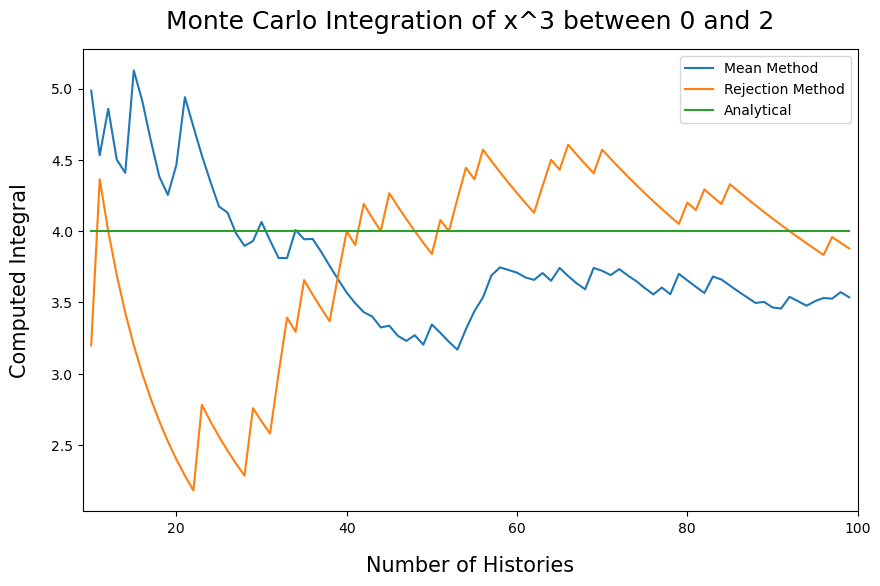

In [72]:
M = 2**31 - 1
I1 = 7**5
initialSeed = int(M / 2)
generator = MultiplicativeCongruentialGenerator(initialSeed, I1, M)
integrator = MCIntegrator(generator)

fig, ax = plt.subplots(figsize=(10,6))
ax, mean_method_computed_integrals, rejection_method_computed_integrals = integrator.visualize_mean_and_rejection_methods(cube, lower=0, upper=2, max_histories=100, ax=ax)
ax.set_xlim(9, 100)
plt.savefig("2a.png")
plt.show()

## 2B

<i>"For each method, compute the slope of the tally fluctuation for the last 2 values of the integrals after the 10th history and plot them in the same chart. Here, the slope between two histories is [I(n+1)-I(n)]/I(n)] where I(n) is the value of the integral after n histories."</i>

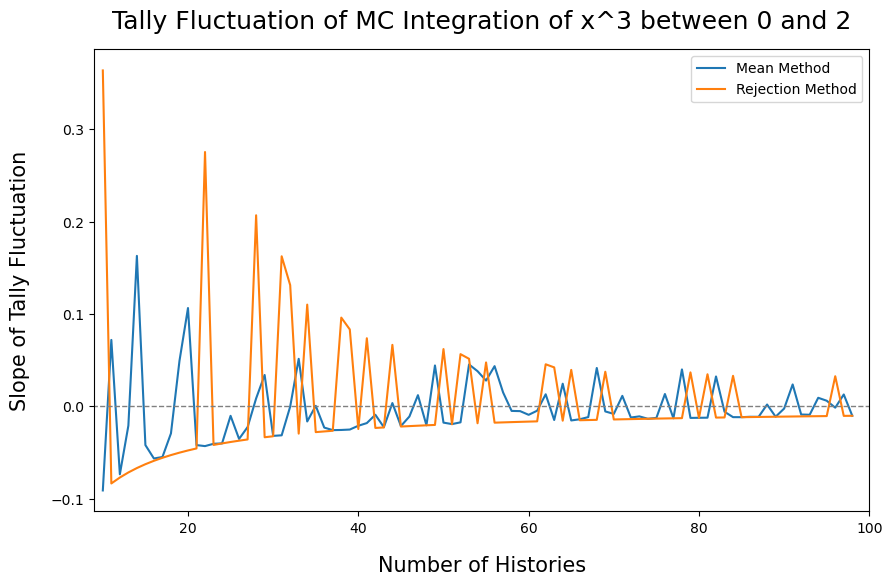

In [73]:
M = 2**31 - 1
I1 = 7**5
initialSeed = int(M / 2)
generator = MultiplicativeCongruentialGenerator(initialSeed, I1, M)
integrator = MCIntegrator(generator)

fig, ax = plt.subplots(figsize=(10,6))
ax, mean_method_tally_slope, rejection_method_tally_slope = integrator.visualize_tally_fluctuations(cube, lower=0, upper=2, max_histories=100, ax=ax)
ax.plot(np.linspace(1, 100, 100), [0]*100, ls="--", lw=1, color="gray")
ax.set_xlim(9, 100)
plt.savefig("2b.png")
plt.show()

# Problem 3

## 3A

<i>"Repeat problem 2 above but use the function g(x)=exp(-x<sup>2</sup>/2)/sqrt(2π) in the interval \[–1,1\]."</i>

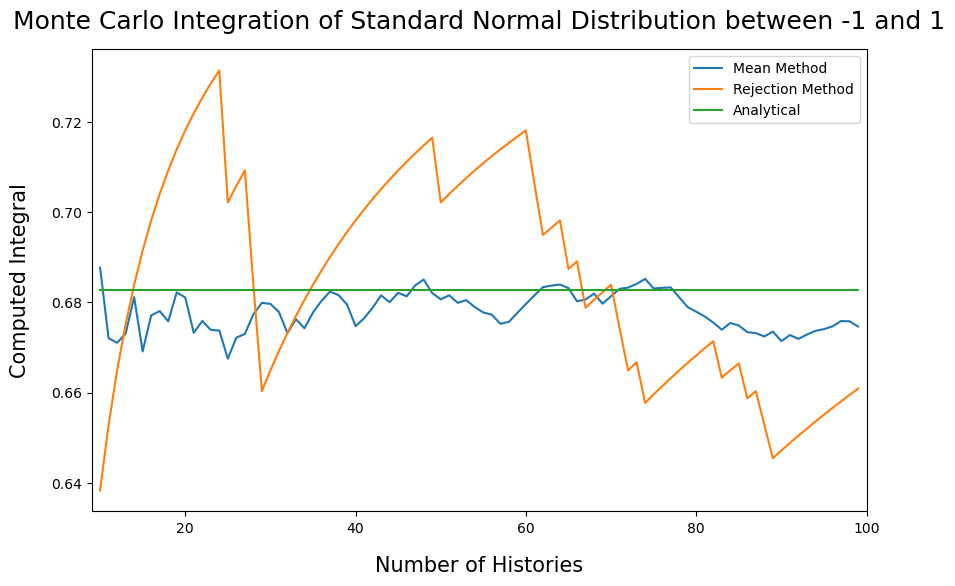

In [74]:
M = 2**31 - 1
I1 = 7**5
initialSeed = int(M / 2)
generator = MultiplicativeCongruentialGenerator(initialSeed, I1, M)
integrator = MCIntegrator(generator)

fig, ax = plt.subplots(figsize=(10,6))
ax, mean_method_computed_integrals, rejection_method_computed_integrals = integrator.visualize_mean_and_rejection_methods(normal, lower=-1, upper=1, max_histories=100, ax=ax)
ax.set_xlim(9, 100)
plt.savefig("3a.png")
plt.show()

## 3B

<i>"Repeat problem 2 above but use the function g(x)=exp(-x<sup>2</sup>/2)/sqrt(2π) in the interval \[–1,1\]."</i>

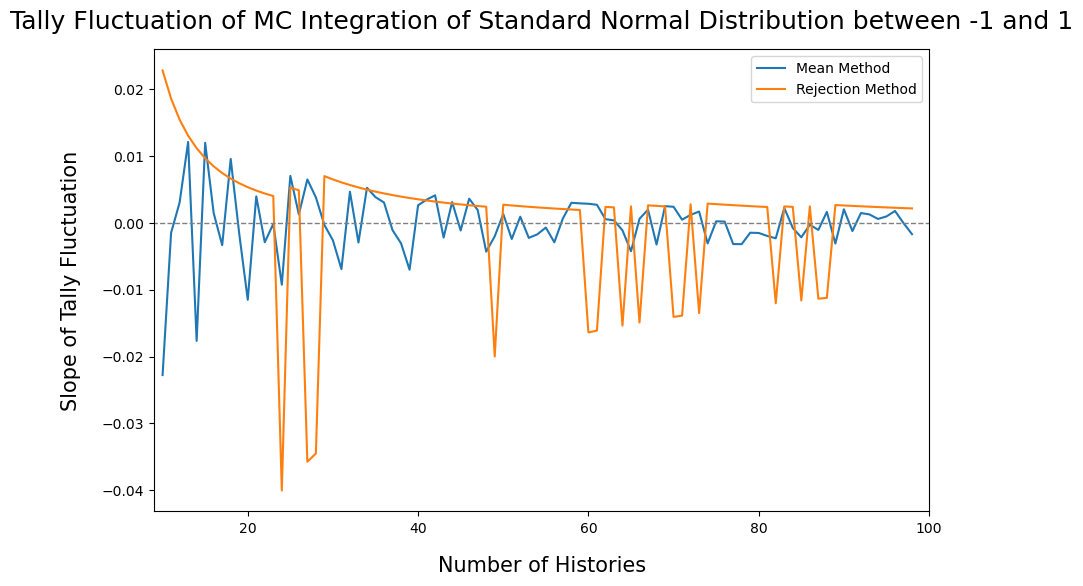

In [75]:
M = 2**31 - 1
I1 = 7**5
initialSeed = int(M / 2)
generator = MultiplicativeCongruentialGenerator(initialSeed, I1, M)
integrator = MCIntegrator(generator)

fig, ax = plt.subplots(figsize=(10,6))
ax, mean_method_tally_slope, rejection_method_tally_slope = integrator.visualize_tally_fluctuations(normal, lower=-1, upper=1, max_histories=100, ax=ax)
ax.plot(np.linspace(1, 100, 100), [0]*100, ls="--", lw=1, color="gray")
ax.set_xlim(9, 100)
plt.savefig("3b.png")
plt.show()

# Problem 4

<i>"Sampling uniformly over a circular disk. Consider the problem of sampling (xi, yj) points uniformly over the disk of radius R centered in the origin of the coordinate system. One method to generate such coordinate pairs is to uniformly sample from the bounding square containing the disc and to use the rejection method to obtain samples inside the disk.</i>

<i>Specifically, the algorithm is:</i>

<i>1. Select ξ<sub>i</sub> and ξ<sub>j</sub> using your random number generator (you can also use an intrinsic routine).</i>

<i>2. Set xi = R(1-2ξi) and yj = R(1-2ξj)</i>

<i>3. Accept this pair if x<sub>i</sub><sup>2</sup> + y<sub>j</sub><sup>2</sup> ≤ R<sup>2</sup></i>

- <i>Write a computer program for this algorithm. Print a table in which the first 50 histories are shown with the (x<sub>i</sub>, y<sub>j</sub>) generated pairs, and whether this is accepted or not (score 1 or 0, respectively).</i>
- <i>The theoretical sampling efficiency of this approach is the ratio of disc-area/square-area = π/4. Using statistical sampling, this would be achieved after an infinite number of samples. Based on your Monte Carlo sampling, prepare a figure that shows how the theoretical sampling efficiency is approached as function of the number of (x<sub>i</sub>, y<sub>j</sub>) pairs generated. Use up to 2000 histories."</i>

<b>For this problem, I simulated a disk of radius 2.</b>

In [78]:
import pandas as pd

M = 2**31 - 1
I1 = 7**5
initialSeed = int(M / 2)
generator = MultiplicativeCongruentialGenerator(initialSeed, I1, M)
integrator = MCIntegrator(generator)

radius = 2
history_sizes, computed_areas, x, y = integrator.integrate_uniform_disk(radius=2, max_histories=50)
coordinates_fmt = list(map(lambda xi, yj: "({:.3f},{:.3f})".format(xi, yj), x, y))
data = {
    "(x,y)": coordinates_fmt,
    "Accepted?": list(map(lambda xi, yj: int(np.sqrt(xi**2 + yj**2) <= radius), x, y))
}
df = pd.DataFrame(data)
"""df.style.set_caption("Randomly Generated Coordinate Pairs").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'gray'),
        ('font-size', '16px')
    ]
}])""" # doesn't show up after pdf conversion
df

,"(x,y)",Accepted?
0,"(-0.000,-0.000)",1
1,"(-0.263,-1.511)",1
2,"(1.083,0.934)",1
3,"(1.562,1.906)",0
4,"(0.642,-1.359)",1
5,"(-1.869,1.233)",0
6,"(-1.039,0.338)",1
7,"(1.931,-0.107)",1
8,"(-1.059,-1.342)",1
9,"(-0.015,1.233)",1


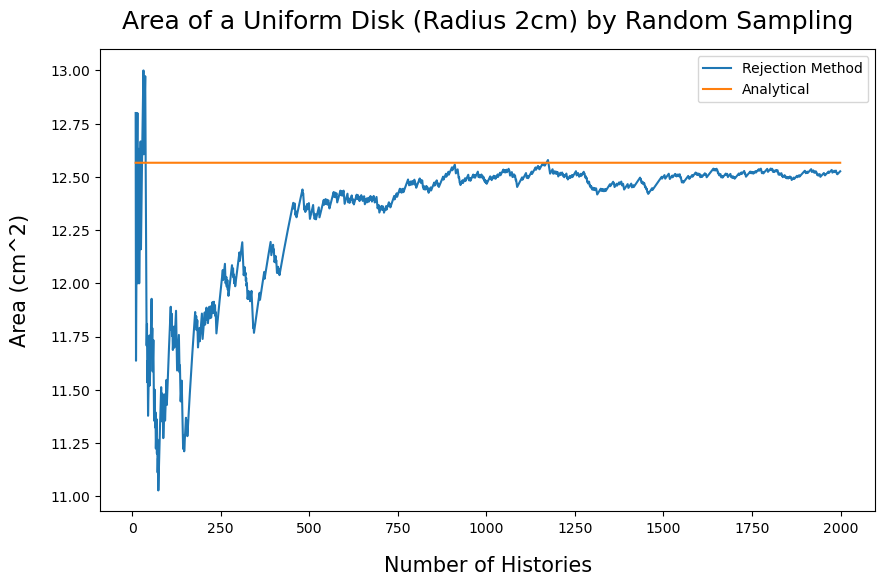

In [77]:
M = 2**31 - 1
I1 = 7**5
initialSeed = int(M / 2)
generator = MultiplicativeCongruentialGenerator(initialSeed, I1, M)
integrator = MCIntegrator(generator)

fig, ax = plt.subplots(figsize=(10,6))
ax, history_sizes, computed_areas, x, y = integrator.visualize_uniform_disk_integral(radius=2, max_histories=2000, ax=ax)
plt.savefig("4.png")
plt.show()

The above curve, which can be easily scaled to a raw sampling efficiency plot by division by a factor of 4R<sup>2</sup>, demonstrates the asymptotic approach of the Monte Carlo approximation to the true area of the uniform disk as the number of histories (randomly generated coordinate pairs) tends toward infinity.